**last update: 08/23/2024**  

This notebook is for Bayesian Gaussian process regression test.

Dataset: 2*2 spatial average in latitude (-15,-10) longitude (35,40). CMIP6 annually, 1850 -2100. 13 models. Short-term oscillations(<10years) & mid-term oscillations(~30years). Consider long-term trend with KGCM.

Goal: Build a proper GPR model for virtual observations by self-designed process.

Design: Fine tune the hyperparameters and consider the evolving uncertainty with more observation years.

Note: In this notebook, there is cross validation(leave-one-out) for 2 rounds(one for kernel structure's selection, one for hyperparameter tuning). 

1: Use the mean value of other models as prior, one model as the virtual observation and plot. Each model will be taken as the virtual observation once(1 round), and the total lml for all the models(all rounds) is used as the evaluation.

2: Use another 5 models from CMIP6(not included in training models) as virtual observations(as test). Use training as piror, fit the GPR to virtual observations and then calculate lml as evaluation.

# Package

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from scipy.optimize import minimize
from pyswarm import pso
from bayes_opt import BayesianOptimization
from scipy.linalg import cholesky, cho_solve,cho_factor,solve_triangular
from scipy.signal import periodogram, welch
from scipy.fft import fft
from statsmodels.tsa.stattools import acf
from sklearn.gaussian_process.kernels import Kernel, WhiteKernel, Matern, RationalQuadratic as RQ, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
import pywt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from bayes_opt import BayesianOptimization, UtilityFunction
from properscoring import crps_gaussian
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Data

In [2]:
rainfall = pd.read_csv('../data/CMIP5_s/s_annual_pr_1850-2099.csv')
rainfall = rainfall.set_index('years',drop=True)
rainfall.columns = [i+1 for i in range(rainfall.shape[1])]

In [3]:
rainfall_yearly = rainfall.copy()

for column in rainfall.columns:
    # Filter data before 1950
    historical_data = rainfall.loc[rainfall.index < 1950, column]
    
    # Calculate mean and std
    mean_value = historical_data.mean()
    std_value = historical_data.std()
    
    # Standardize the column using mean and std
    rainfall_yearly[column] = (rainfall[column] - mean_value) / std_value

# Save the standardized data to a new CSV file
# export_path = "../data/CMIP5_s/scaled_s_annual_pr_1850-2100.csv"
# rainfall_yearly.to_csv(export_path)

In [4]:
mod_ids = range(0, rainfall_yearly.shape[1])
Nobs = 166 # 1850-2015
year = np.array(rainfall_yearly.index)

# Function

In [5]:
def log_marginal_likelihood_manual(kernel, y_train):
    L = np.linalg.cholesky(kernel)
    alpha = cho_solve((L, True), y_train)
    log_likelihood = -0.5 * np.dot(y_train.T, alpha)
    log_likelihood -= np.sum(np.log(np.diag(L)))
    log_likelihood -= len(y_train) / 2 * np.log(2 * np.pi)
    return log_likelihood

def Choleskey_trick(A, diff, K_os):
    L = np.linalg.cholesky(A)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, diff))
    v = np.linalg.solve(L, K_os)
    return alpha, v, L

def compute_prior_and_posterior(K_full, y_train, y_test, Nobs):
    N_all = Nobs * 2 
    K_o = K_full[:Nobs, :Nobs] 
    K_s = K_full[Nobs:, Nobs:] 
    K_os = K_full[:Nobs, Nobs:]

    tmp = np.vstack((y_train.iloc[:Nobs, :], y_train))
    smoothedMean = np.mean(tmp, axis=1)
    mu = smoothedMean[:Nobs]  
    mu_s = smoothedMean[Nobs:] 

    y = y_test[:Nobs].values
    diff = y - mu
    if diff.ndim == 1:
        diff = diff[:, np.newaxis]

    A = K_o
    eigenvalues = np.linalg.eigvalsh(A)
    assert np.all(eigenvalues >= 0)
    
    alpha, v, L = Choleskey_trick(A, diff, K_os)
    f = mu_s + np.dot(K_os.T, alpha).ravel()  

    Sigma_s = K_s - np.dot(v.T, v)
    
    y_test_part = y_test[Nobs:].values 
    mu_test_part = mu_s[-len(y_test_part):]
    diff_test = y_test_part - mu_test_part  
    if diff_test.ndim == 1:
        diff_test = diff_test[:, np.newaxis]

    K_test = K_full[N_all:, N_all:]
    A_test = K_test+ 1e-6 * np.eye(K_test.shape[0])
    K_test_os = K_full[N_all:, :Nobs]
    alpha_test, v_test, L_test = Choleskey_trick(A_test, diff_test, K_test_os)
    lml = -0.5 * (np.dot(diff_test.T, alpha_test) + 2 * np.sum(np.log(np.diag(L_test)))).item()

    prior_mu = np.mean(tmp, axis=1)[Nobs:]
    prior_cov = K_s
    post_mu = f
    post_cov = Sigma_s

    return prior_mu, prior_cov, post_mu, post_cov, lml

In [31]:
def kernel_tune(mod_ids, Nobs, data, pbounds, kernel_func):
    np.float = np.float64

    def compute_KGCM(data, Nobs):
        tmp = np.vstack((data.iloc[:Nobs, :], data))
        smoothedCov = np.cov(tmp, rowvar=True)
        KGCM = smoothedCov
        return KGCM

    def gp_target(data, KGCM, current_mod_ids, **params):
        total_lml = 0.0
        kernel = kernel_func(params)
        for mod_id in current_mod_ids:
            if mod_id >= data.shape[1]:
                print(f"mod_id {mod_id} is out of bounds for data with {data.shape[1]} columns.")
                continue
            try:
                oos_gcm = data.iloc[:, mod_id].values
            except IndexError as e:
                print(f"IndexError for mod_id {mod_id}: {e}")
                continue

            X_train = np.arange(Nobs).reshape(-1, 1)
            y_train = oos_gcm[:Nobs]

            try:
                K_kernel = kernel(X_train, X_train)
                K_combined = K_kernel + KGCM + 1e-6 * np.eye(K_kernel.shape[0])
                lml = log_marginal_likelihood_manual(K_combined, y_train)
                
                if np.isreal(lml):
                    total_lml += lml
                else:
                    total_lml -= np.inf
            except (TypeError, np.linalg.LinAlgError) as e:
                print("Error in kernel construction or GP fitting:", e)
                total_lml -= np.inf

        return total_lml

    total_lml_sum = 0.0
    KGCM = compute_KGCM(data, Nobs)
    KGCM_o = KGCM[:Nobs, :Nobs]
        
    optimizer = BayesianOptimization(
            f=lambda **params: gp_target(data, KGCM_o, list(range(len(mod_ids))), **params), 
            pbounds=pbounds, 
            random_state=90
        )

    init_points = 50
    n_iter = 50

    best_params = None

    with tqdm(total=init_points + n_iter, desc=f"Optimization Progress") as pbar:
        try:
            optimizer.maximize(init_points=init_points, n_iter=n_iter)
            pbar.update(init_points + n_iter)
        except Exception as e:
            print("An error occurred during optimization:", e)
            if 'params' in optimizer.max:
                best_params = optimizer.max['params']
                kernel = kernel_func(best_params)
            else:
                best_params = None

                    
    print(f"Best objective function value: {optimizer.max['target']}")
        
    if best_params is not None:
        try:
            kernel = kernel_func(best_params)
            print("Best kernel is:", kernel)

            X_full = np.arange(data.shape[0] + Nobs).reshape(-1, 1)
            K_full = kernel(X_full, X_full)

            lml_all = 0
            for i in range(data.shape[1]): 
                prior_mu, prior_cov, post_mu, post_cov, lml = compute_prior_and_posterior(K_full, data, data.iloc[:, i], Nobs)
                lml_all += lml

            print(f"Total test lml: {lml_all}")
            prior_mu, prior_cov, post_mu, post_cov, lml = compute_prior_and_posterior(K_full, data, data.iloc[:, 0], Nobs)
            plot_prior_posterior(year, data.iloc[:, 0], prior_mu, prior_cov, post_mu, post_cov)
        except Exception as e:
            print(f"An error occurred: {e}")
            


In [10]:
def plot_prior_posterior(X, obs, prior_mu, prior_cov, post_mu, post_cov):
    std_prior = np.sqrt(np.diag(prior_cov))
    std_post = np.sqrt(np.diag(post_cov))
    
    def rgb_to_normalized(rgb):
        return [x / 255.0 for x in rgb]
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(X.flatten(), post_mu - 1.96*std_post, post_mu + 1.96*std_post, alpha=0.2, color=rgb_to_normalized((164, 81, 79)), label='Posterior 95% CI')
    plt.plot(X, obs, color=rgb_to_normalized((191, 177, 208)), label='Virtual Observation')
    plt.plot(X, prior_mu, color=rgb_to_normalized((255, 235, 173)), label='Prior Mean')
    # plt.fill_between(X.flatten(), prior_mu - 1.96*std_prior, prior_mu + 1.96*std_prior, alpha=0.2, color='blue', label='Prior 95% CI')
    plt.plot(X, post_mu, color=rgb_to_normalized((164, 81, 79)), label='Posterior Mean')
    plt.axvline(x=year[Nobs], color='grey', linestyle='--', label='Historical/Future Split')
    plt.title('Prior vs Posterior')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()



# Kernel Tune

Test different kernels. Note that '_' means the sum of kernel, and kernel1kernel2 means kernel1*kernel2. Number means how many kernels we use of the same structure.

With other kernels to be implementation. Such as some kernels to make an addition or product.

## poly with narrow uncertainty

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -7.733e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  1.869    |  2.684    |  0.3341   |  5.578    |  4.006    |
|  2        | -7.384e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  2.589    |  1.952    |  0.5525   |  6.303    |  5.014    |
|  3        | -6.717e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.8102   |  8.077    |  0.8115   |  3.203    |  5.377    |
|  4        | -7.668e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  6.236    |  5.996    |  0.6816   |  6.355    |  4.84     |
|  5        | -8.009e+0 |  5.93e-07 |  0.9608   |  0.3556   |  4.844    |  8.133    |  6.072    |  0.6352   |  4.667    |  6.125    |
|  6        | -7.753e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:01<?, ?it/s]

|  47       | -6.544e+0 |  8.113e-0 |  0.4241   |  0.611    |  7.739    |  2.987    |  3.185    |  0.09994  |  4.608    |  5.31     |
|  48       | -6.004e+0 |  1.053e-0 |  0.4904   |  0.4606   |  9.028    |  0.4369   |  3.533    |  0.8257   |  4.177    |  6.884    |
|  49       | -6.577e+0 |  5.902e-0 |  0.5604   |  0.8046   |  8.049    |  5.609    |  1.126    |  0.2962   |  4.084    |  6.174    |
|  50       | -7.58e+07 |  7.222e-0 |  0.3129   |  0.5126   |  1.084    |  2.199    |  4.192    |  0.4688   |  4.675    |  3.761    |
An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -2857.1864721921265
Best kernel is: 0.1**2 * 0.000807**2 * DotProduct(sigma_0=8.62) ** 2 + 0.401**2 * ExpSineSquared(length_scale=1.03, periodicity=5.72) + 0.928**2 * ExpSineSquared(length_scale=0.011, periodicity=5.66) + WhiteKernel(noise_level=0.00831)


Total test lml: -887.4421469831258


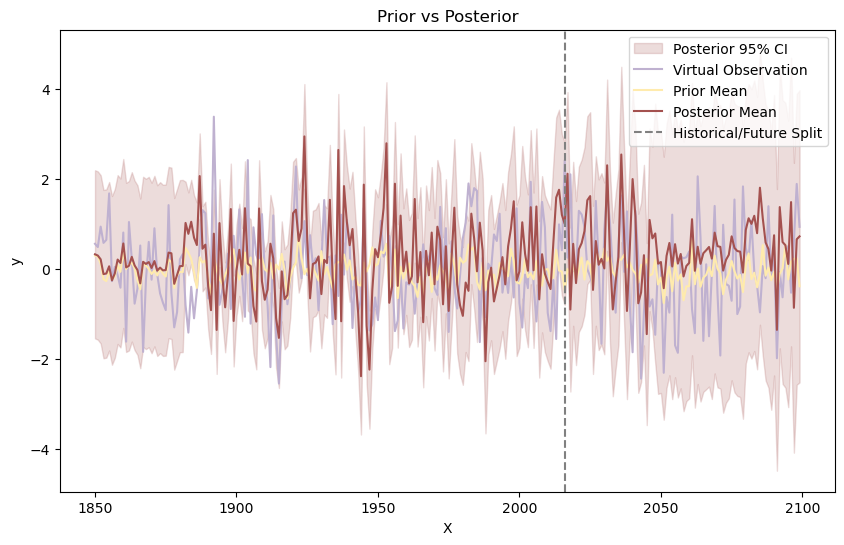

In [32]:
def time_dependent_noise(t, base_noise=1e-5, growth_rate=1e-4):
    return base_noise + growth_rate * t

def pe2_poly_growing_noise(best_params, Nobs=166):
    t = np.linspace(0, Nobs, Nobs)  
    noise_level = time_dependent_noise(t)
    kernel = (
        0.01 * C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=noise_level.mean())  
    )
    return kernel

pbounds = {
    'c1': (0.0000001, 0.000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 1e1),
    'per1': (3, 7),
    'ls2': (1e-2, 1e1),
    'per2': (3, 7),
    'noise': (1e-6, 1),  
    'dp_sigma_0': (1e-3, 10),
}

kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly_growing_noise)


-1008.3960993778683

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -7.733e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  1.869    |  2.684    |  0.3341   |  5.578    |  4.006    |
|  2        | -7.384e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  2.589    |  1.952    |  0.5525   |  6.303    |  5.014    |
|  3        | -6.717e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.8102   |  8.077    |  0.8115   |  3.203    |  5.377    |
|  4        | -7.668e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  6.236    |  5.996    |  0.6816   |  6.355    |  4.84     |
|  5        | -8.009e+0 |  5.93e-07 |  0.9608   |  0.3556   |  4.844    |  8.133    |  6.072    |  0.6352   |  4.667    |  6.125    |
|  6        | -7.754e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:01<?, ?it/s]


Best objective function value: -2941.255436642681
Best kernel is: 3.05**2 * 0.000807**2 * DotProduct(sigma_0=8.62) ** 2 + 0.401**2 * ExpSineSquared(length_scale=1.03, periodicity=5.72) + 0.928**2 * ExpSineSquared(length_scale=0.011, periodicity=5.66) + WhiteKernel(noise_level=0.485)
Total test lml: -958.3493618439425


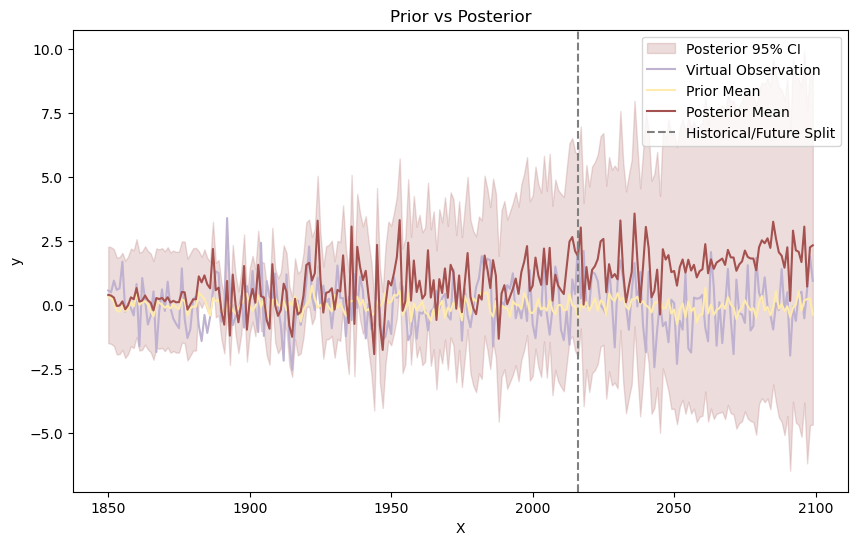

In [46]:
def pe2_poly(best_params, Nobs=166):
    t = np.linspace(0, Nobs, Nobs) 
    weight_factor = 0.1  
    time_weight = 1 + weight_factor * t.mean()
    
    kernel = (
        time_weight * C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (0.0000001, 0.000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 1e1),
    'per1': (3, 7),
    'ls2': (1e-2, 1e1),
    'per2': (3, 7),
    'noise': (1e-6, 1),
    'dp_sigma_0': (1e-3, 10),
}

kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly)


Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -7.148e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  0.9385   |  1.346    |  0.3341   |  5.578    |  4.006    |
|  2        | -7.087e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  1.298    |  0.9798   |  0.5525   |  6.303    |  5.014    |
|  3        | -6.235e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.4097   |  4.039    |  0.8115   |  3.203    |  5.377    |
|  4        | -7.388e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  3.12     |  3.0      |  0.6816   |  6.355    |  4.84     |
|  5        | -7.824e+0 |  5.93e-08 |  0.9608   |  0.3556   |  4.844    |  4.068    |  3.038    |  0.6352   |  4.667    |  6.125    |
|  6        | -7.441e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:01<?, ?it/s]


Best objective function value: -2885.966841098537
Best kernel is: 0.365**2 * 0.000255**2 * DotProduct(sigma_0=8.62) ** 2 + 0.401**2 * ExpSineSquared(length_scale=0.521, periodicity=5.72) + 0.928**2 * ExpSineSquared(length_scale=0.0105, periodicity=5.66) + WhiteKernel(noise_level=0.485)
Total test lml: -890.5679438961536


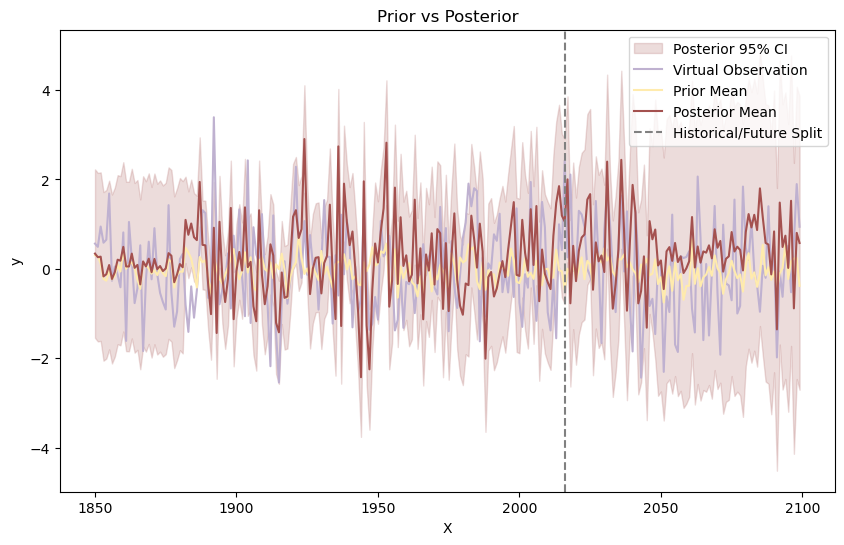

In [45]:
def pe2_poly(best_params, Nobs=166):
    t = np.linspace(0, Nobs, Nobs)  
    weight_factor = 0.001 
    time_weight = 0.05 + weight_factor * t.mean()
    
    kernel = (
        time_weight * C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (0.00000001, 0.0000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 10),
    'per1': (3, 7),
    'ls2': (1e-2, 10),
    'per2': (3, 7),
    'noise': (1e-6, 1),
    'dp_sigma_0': (1e-3, 10),
}

kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly)


Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.384e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  1.869    |  2.684    |  0.3341   |  5.578    |  4.006    |
|  2        | -3.486e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  2.589    |  1.952    |  0.5525   |  6.303    |  5.014    |
|  3        | -2.671e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.8102   |  8.077    |  0.8115   |  3.203    |  5.377    |
|  4        | -3.248e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  6.236    |  5.996    |  0.6816   |  6.355    |  4.84     |
|  5        | -3.853e+0 |  5.93e-08 |  0.9608   |  0.3556   |  4.844    |  8.133    |  6.072    |  0.6352   |  4.667    |  6.125    |
|  6        | -3.512e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -1816.0918818018233
Best kernel is: 0.316**2 * 0.000255**2 * DotProduct(sigma_0=8.62) ** 2 + 0.401**2 * ExpSineSquared(length_scale=1.03, periodicity=5.72) + 0.928**2 * ExpSineSquared(length_scale=0.011, periodicity=5.66) + WhiteKernel(noise_level=0.485)


Total test lml: -1409.7213200452668


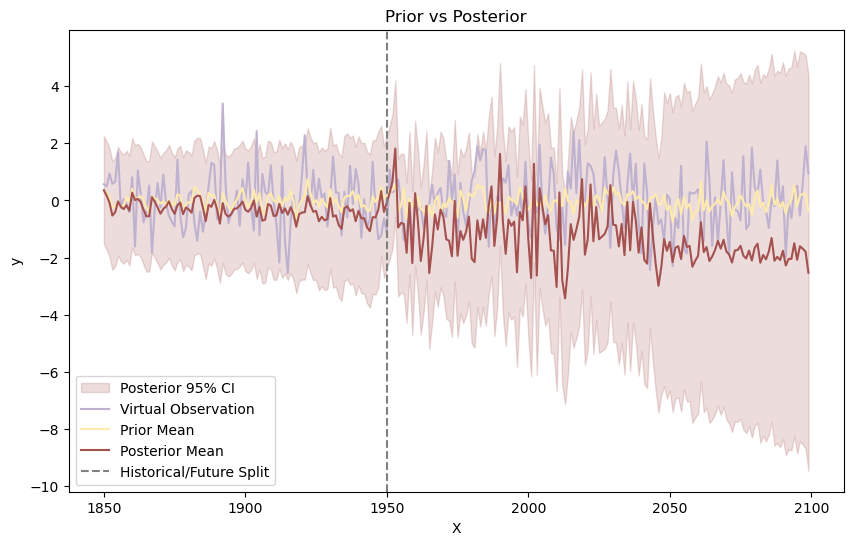

In [48]:
def pe2_poly(best_params, Nobs=100):
    t = np.linspace(0, Nobs, Nobs)
    weight_factor = 0.001 
    time_weight = 0.05 + weight_factor * t.mean()
    
    kernel = (
        time_weight * C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (0.00000001, 0.0000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 10),
    'per1': (3, 7),
    'ls2': (1e-2, 10),
    'per2': (3, 7),
    'noise': (1e-6, 1),
    'dp_sigma_0': (1e-3, 10),
}
Nobs=100
kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -6.931e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  1.869    |  2.684    |  0.3341   |  5.578    |  4.006    |
|  2        | -2.965e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  2.589    |  1.952    |  0.5525   |  6.303    |  5.014    |
|  3        | -4.374e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.8102   |  8.077    |  0.8115   |  3.203    |  5.377    |
|  4        | -6.009e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  6.236    |  5.996    |  0.6816   |  6.355    |  4.84     |
|  5        | -6.639e+0 |  5.93e-08 |  0.9608   |  0.3556   |  4.844    |  8.133    |  6.072    |  0.6352   |  4.667    |  6.125    |
|  6        | -8.936e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -724.5133680087226
Best kernel is: 0.274**2 * 0.00021**2 * DotProduct(sigma_0=7.66) ** 2 + 0.574**2 * ExpSineSquared(length_scale=0.0926, periodicity=5.32) + 0.702**2 * ExpSineSquared(length_scale=9.37, periodicity=3.78) + WhiteKernel(noise_level=0.228)


Total test lml: -642891027.3149593


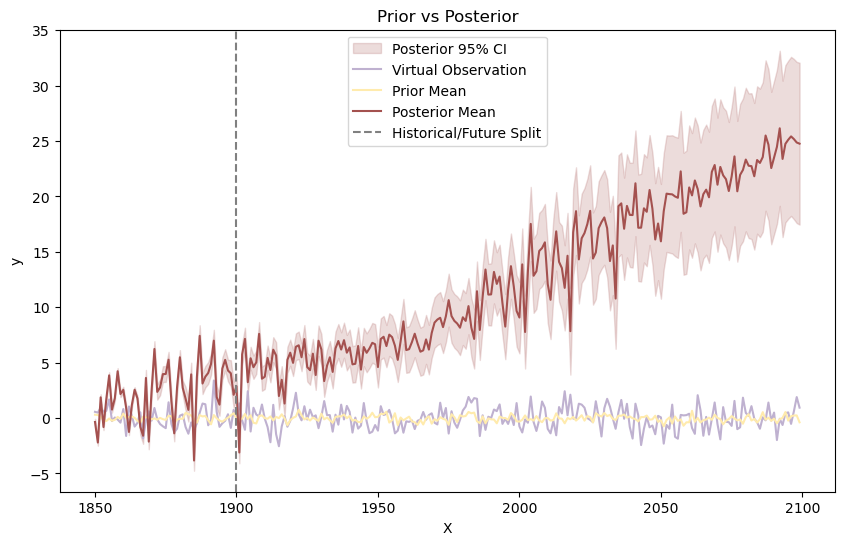

In [49]:
def pe2_poly(best_params, Nobs=50):
    t = np.linspace(0, Nobs, Nobs)  
    weight_factor = 0.001 
    time_weight = 0.05 + weight_factor * t.mean()
    
    kernel = (
        time_weight * C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (0.00000001, 0.0000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 10),
    'per1': (3, 7),
    'ls2': (1e-2, 10),
    'per2': (3, 7),
    'noise': (1e-6, 1),
    'dp_sigma_0': (1e-3, 10),
}
Nobs=50
kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -9.499e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  1.869    |  2.684    |  0.3341   |  5.578    |  4.006    |
|  2        | -9.081e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  2.589    |  1.952    |  0.5525   |  6.303    |  5.014    |
|  3        | -8.459e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.8102   |  8.077    |  0.8115   |  3.203    |  5.377    |
|  4        | -9.294e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  6.236    |  5.996    |  0.6816   |  6.355    |  4.84     |
|  5        | -9.836e+0 |  5.93e-08 |  0.9608   |  0.3556   |  4.844    |  8.133    |  6.072    |  0.6352   |  4.667    |  6.125    |
|  6        | -9.327e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:02<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -3371.9624787678067
Best kernel is: 0.387**2 * 0.000255**2 * DotProduct(sigma_0=8.62) ** 2 + 0.401**2 * ExpSineSquared(length_scale=1.03, periodicity=5.72) + 0.928**2 * ExpSineSquared(length_scale=0.011, periodicity=5.66) + WhiteKernel(noise_level=0.485)


Total test lml: -571.2384784561237


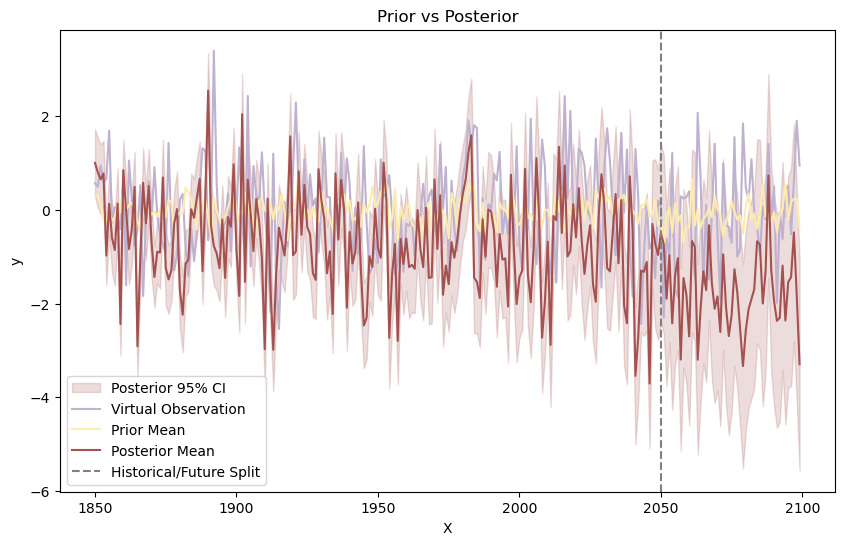

In [50]:
def pe2_poly(best_params, Nobs=200):
    t = np.linspace(0, Nobs, Nobs) 
    weight_factor = 0.001  
    time_weight = 0.05 + weight_factor * t.mean()
    
    kernel = (
        time_weight * C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (0.00000001, 0.0000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 10),
    'per1': (3, 7),
    'ls2': (1e-2, 10),
    'per2': (3, 7),
    'noise': (1e-6, 1),
    'dp_sigma_0': (1e-3, 10),
}
Nobs=200
kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     | dp_sig... |    ls1    |    ls2    |   noise   |   per1    |   per2    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -7.733e+0 |  2.377e-0 |  0.2419   |  0.9869   |  9.045    |  1.869    |  2.684    |  0.3341   |  5.578    |  4.006    |
|  2        | -7.384e+0 |  6.717e-0 |  0.6218   |  0.6569   |  3.678    |  2.589    |  1.952    |  0.5525   |  6.303    |  5.014    |
|  3        | -6.717e+0 |  7.188e-0 |  0.7836   |  0.6781   |  3.851    |  0.8102   |  8.077    |  0.8115   |  3.203    |  5.377    |
|  4        | -7.668e+0 |  9.714e-0 |  0.9876   |  0.8378   |  6.899    |  6.236    |  5.996    |  0.6816   |  6.355    |  4.84     |
|  5        | -8.009e+0 |  5.93e-09 |  0.9608   |  0.3556   |  4.844    |  8.133    |  6.072    |  0.6352   |  4.667    |  6.125    |
|  6        | -7.754e+0 |  3.738e-0 |  0.7837   |  0.4599   | 

Optimization Progress:   0%|          | 0/100 [00:01<?, ?it/s]


Best objective function value: -2827.102506926042
Best kernel is: 0.1**2 * 8.07e-05**2 * DotProduct(sigma_0=8.62) ** 2 + 0.401**2 * ExpSineSquared(length_scale=1.03, periodicity=5.72) + 0.928**2 * ExpSineSquared(length_scale=0.011, periodicity=5.66) + WhiteKernel(noise_level=0.485)
Total test lml: -851.9665678727152


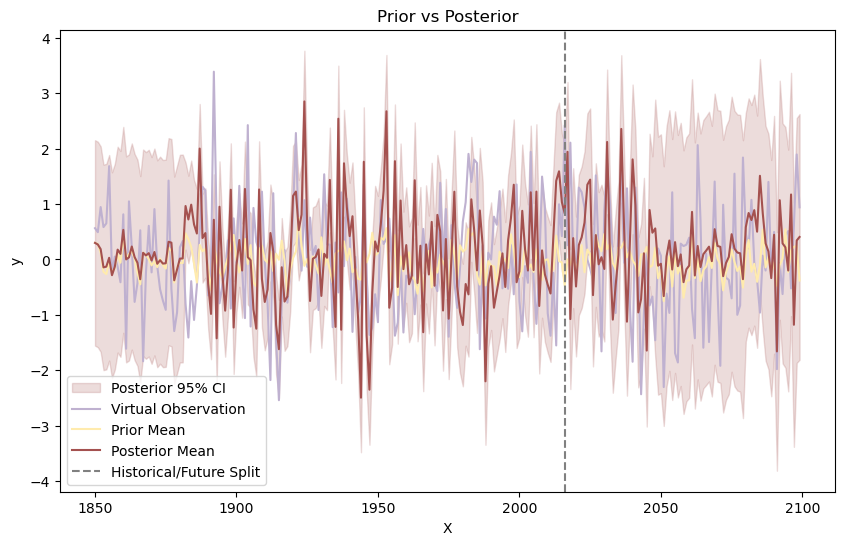

In [34]:
def pe2_poly(best_params):
    kernel = (
        0.01* C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (0.000000001, 0.00000001),
    'c2': (0.1, 1),
    'c3': (0.1, 1),
    'ls1': (1e-2, 1e1),
    'per1': (3, 7),
    'ls2': (1e-2, 1e1),
    'per2': (3, 7),
    'noise': (1e-6, 1),
    'dp_sigma_0': (1e-3, 10),
}
kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, pe2_poly)

-973.0950823859205

## rbf*pe

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   |    c2     |    c3     |   c_rbf   |    ls1    |    ls2    |   noise   |   per1    |   per2    |  rbf_ls1  |  rbf_ls2  |  rbf_ls3  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -4.005e+0 |  0.5439   |  0.5573   |  2.958    |  90.45    |  1.869    |  0.2677   |  4.336    |  5.578    |  25.15    |  6.356    |  5.802    |
|  2        | -2.09e+05 |  1.895    |  1.167    |  0.8487   |  19.44    |  5.53     |  0.8256   |  5.014    |  5.75     |  75.96    |  6.427    |  3.856    |
|  3        | -4.234e+0 |  0.3323   |  2.442    |  2.453    |  5.092    |  5.947    |  0.9683   |  6.945    |  6.279    |  68.99    |  6.236    |  5.996    |
|  4        | -2.587e+0 |  2.077    |  2.532    |  1.434    |  54.78    |  9.565    |  0.284    |  4.937    |  6.253    |  60.69    |  6.355    |  4.173    |
|  5        | -3.715e+0 |  2.366    |  0.9822   |  2

Optimization Progress:   0%|          | 0/100 [00:02<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -1861.0862634281966
Best kernel is: 0.449**2 * ExpSineSquared(length_scale=80.9, periodicity=4.03) * RBF(length_scale=25.2) + 0.964**2 * ExpSineSquared(length_scale=3.85, periodicity=6.28) * RBF(length_scale=8.63) + 0.434**2 * RBF(length_scale=0.321) + WhiteKernel(noise_level=0.233)


Total test lml: -2523.337336406795


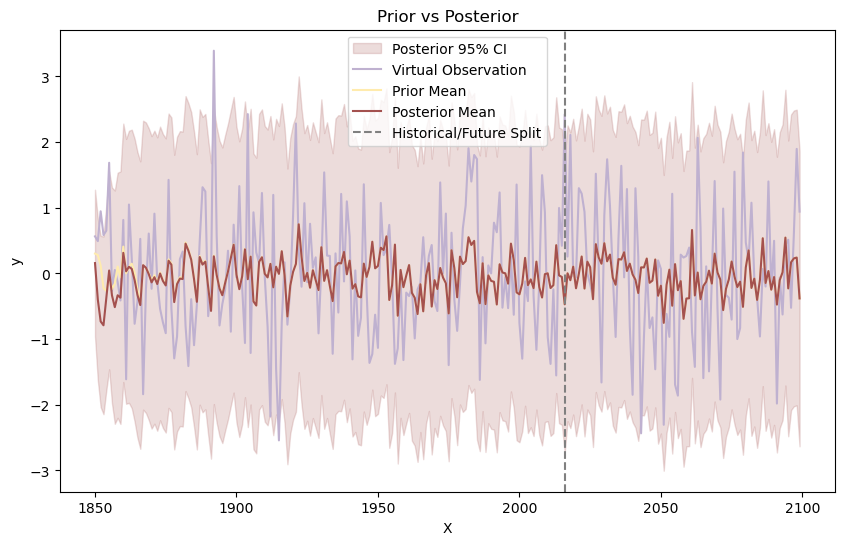

In [35]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel as C

def rbfpe2_rbf(best_params):
    kernel = (
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) * RBF(length_scale=best_params['rbf_ls1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) * RBF(length_scale=best_params['rbf_ls2']) +
        C(best_params['c_rbf']) * RBF(length_scale=best_params['rbf_ls3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c2': (1e-1, 3),
    'c3': (1e-1, 3),
    'c_rbf': (1e-1, 3),        
    'ls1': (1e-2, 100),
    'per1': (3, 7),
    'ls2': (1e-2, 10),
    'per2': (3, 7),
    'rbf_ls1': (1e-2, 100),   
    'rbf_ls2': (1e-2, 10),     
    'rbf_ls3': (1e-2, 10),    
    'noise': (1e-6, 1),
}
kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, rbfpe2_rbf)


-2972.4730779882593

## Poly(PE)

In [21]:
class CustomPolynomialKernel(Kernel):
    def __init__(self, degree=2, periods=[1, 1, 1], include_bias=False):
        self.degree = degree
        self.periods = periods if isinstance(periods, (list, np.ndarray)) else [periods]
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=self.include_bias)
    
    def periodic_transform(self, X):
        return np.hstack([np.cos(2 * np.pi * X / p) for p in self.periods] +
                         [np.sin(2 * np.pi * X / p) for p in self.periods])
    
    def __call__(self, X, Y=None, eval_gradient=False):
        X_transformed = self.periodic_transform(X)
        if Y is None:
            Y_transformed = X_transformed
        else:
            Y_transformed = self.periodic_transform(Y)
        
        K = self.poly.fit_transform(X_transformed).dot(self.poly.fit_transform(Y_transformed).T)
        
        if eval_gradient:
            K_gradient = np.zeros((X_transformed.shape[0], Y_transformed.shape[0], 0))
            return K, K_gradient
        else:
            return K
    
    def diag(self, X):
        return np.diag(self.__call__(X))
    
    def is_stationary(self):
        return False

### eye-bowling best

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | constant5 | matern... | noise_... |    nu     |  period1  |  period2  |  period3  | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.697e+0 |  0.1539   |  0.1585   |  0.9855   |  0.9046   |  0.1869   |  27.5     |  0.3341   |  1.789    |  4.006    |  5.541    |  5.319    |  61.88    |  36.78    |  25.82    |
|  2        | -2.252e+0 |  0.1952   |  0.553    |  0.8258   |  0.5039   |  0.6879   |  76.2     |  0.6423   |  1.27     |  3.32     |  6.23     |  6.246    |  5.092    |  59.43    |  96.83    |
|  3        | -4.94e+06 |  0.9862   |  0.82     |  0.6902   |  0.6236   |  0.5996   |  68.48    |  0.8387   |  1.42     |  5.191    |  6.826    |  4.136    |  48.44    |  81.32    |  60.69    |
|  4        | -7.369e+0 |  0.6

Optimization Progress:   0%|          | 0/100 [00:15<?, ?it/s]

|  50       | -3.883e+0 |  0.8541   |  0.3057   |  0.1377   |  0.9616   |  0.6426   |  90.95    |  0.4688   |  1.856    |  3.157    |  4.96     |  5.472    |  23.71    |  93.81    |  21.05    |
An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -2125.5175970013797
Best kernel is: 0.654**2 * CustomPolynomialKernel() + 0.308**2 * RationalQuadratic(alpha=47.7, length_scale=74.2) + 0.527**2 * Matern(length_scale=2.97, nu=0.879) + 0.691**2 * RBF(length_scale=47.1) + WhiteKernel(noise_level=0.47)


Total test lml: -12830.564181320691


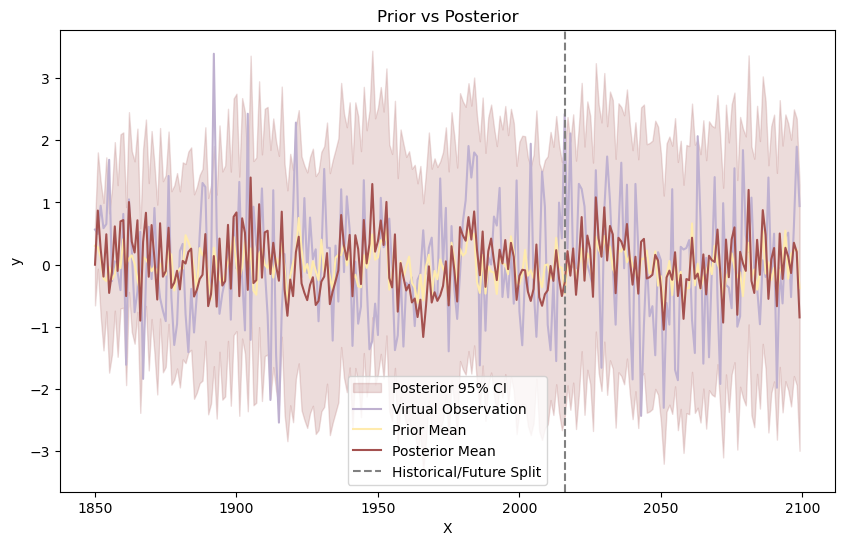

In [36]:
def polype3_rq_matern_rbf(best_params):
    custom_poly_kernel = C(best_params['constant1']) * CustomPolynomialKernel(degree=2, periods=[best_params['period1'], best_params['period2'], best_params['period3']])
    original_kernel = (
        C(best_params['constant2']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        C(best_params['constant3']) * Matern(length_scale=best_params['matern_length'], nu=best_params['nu']) +
        C(best_params['constant4']) * RBF(length_scale=best_params['rbf_length']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return custom_poly_kernel + original_kernel

pbounds = {
    'period1': (3,7),
    'period2': (3,7),
    'period3': (3,7),
    'rq_alpha': (1e-2, 1e2),
    'matern_length': (1e0, 1e2),
    'noise_level': (1e-6, 1),
    'constant1': (1e-3, 1),
    'constant2': (1e-3, 1),
    'constant3': (1e-3, 1),
    'constant4': (1e-3, 1),
    'constant5': (1e-3, 1),
    'rbf_length': (1e-2, 1e2),
    'nu': (0.5, 2.5),
    'rq_ls': (1e-2, 1e2)
}

kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, polype3_rq_matern_rbf)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | constant5 | constant6 | matern... | noise_... |    nu     |  period1  |  period2  |  period3  | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.234e+0 |  0.1539   |  0.1585   |  0.9855   |  0.4523   |  0.09385  |  0.1346   |  4.006    |  0.6446   |  1.003    |  5.541    |  5.319    |  5.475    |  3.684    |  0.2656   |  1.952    |
|  2        | -3.153e+0 |  0.553    |  0.8258   |  0.5039   |  0.3441   |  0.38     |  0.3215   |  4.465    |  0.0801   |  2.115    |  6.246    |  3.203    |  5.377    |  9.683    |  0.9864   |  8.2      |
|  3        | -4.782e+0 |  0.6902   |  0.6236   |  0.5996   |  0.3411   |  0.4195   |  0.2305   |  5.93     |  0.9565   |  1.068    |  4.937    |  6.253    |  5.427    |  6.355

Optimization Progress:   0%|          | 0/100 [00:13<?, ?it/s]

|  50       | -7.113e+0 |  0.009512 |  0.7603   |  0.4021   |  0.2557   |  0.2534   |  0.3674   |  9.441    |  0.16     |  2.396    |  6.92     |  5.391    |  3.421    |  8.066    |  0.06212  |  5.811    |
An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -1735.437779369157
Best kernel is: 0.209**2 * CustomPolynomialKernel() + 0.984**2 * CustomPolynomialKernel() + 0.798**2 * CustomPolynomialKernel() + 0.212**2 * RationalQuadratic(alpha=0.541, length_scale=6.4) + 0.64**2 * Matern(length_scale=6.97, nu=0.79) + 0.254**2 * RBF(length_scale=0.66) + WhiteKernel(noise_level=0.894)


Total test lml: -7124.310090715024


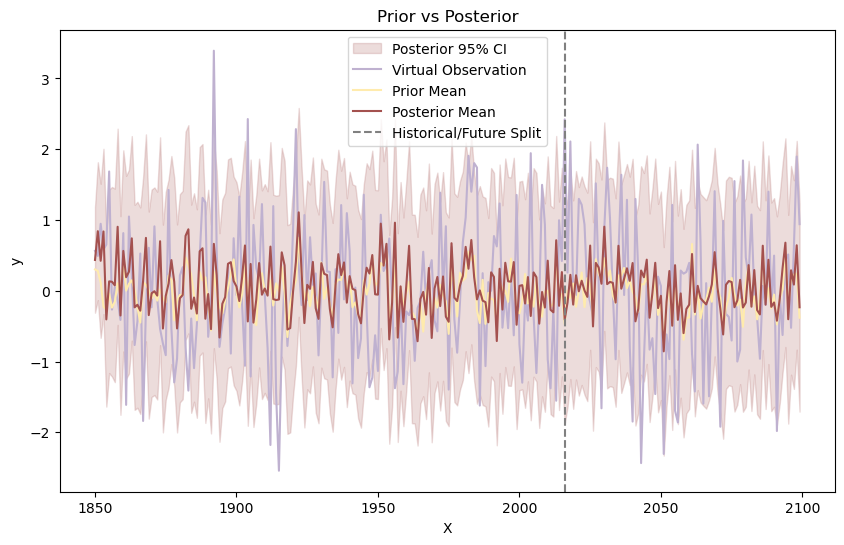

In [37]:
def polype3_rq_matern_rbf_true(best_params):
    custom_poly_kernel1 = C(best_params['constant1']) * CustomPolynomialKernel(degree=2, periods=best_params['period1'])
    custom_poly_kernel2 = C(best_params['constant2']) * CustomPolynomialKernel(degree=2, periods=best_params['period2'])
    custom_poly_kernel3 = C(best_params['constant3']) * CustomPolynomialKernel(degree=2, periods=best_params['period3'])
    
    original_kernel = (
        C(best_params['constant4']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        C(best_params['constant5']) * Matern(length_scale=best_params['matern_length'], nu=best_params['nu']) +
        C(best_params['constant6']) * RBF(length_scale=best_params['rbf_length']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    
    return custom_poly_kernel1 + custom_poly_kernel2 + custom_poly_kernel3 + original_kernel

pbounds = {
    'period1':(3,7),
    'period2': (3,7),
    'period3': (3,7),
    'rq_alpha': (1e-2, 1),
    'matern_length': (1e0, 10),
    'noise_level': (1e-6, 1),
    'constant1': (1e-3, 1),
    'constant2': (1e-3, 1),
    'constant3': (1e-3, 1),
    'constant4': (1e-3, 0.5),
    'constant5': (1e-3, 0.5),
    'constant6': (1e-3, 0.5),
    'rbf_length': (1e-2, 10),
    'nu': (0.5, 2.5),
    'rq_ls': (1e-2, 10)
}

kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, polype3_rq_matern_rbf_true)


## original

Optimization Progress:   0%|          | 0/100 [00:00<?, ?it/s]

|   iter    |  target   | consta... | noise_... | rbf_le... |
-------------------------------------------------------------
|  1        | -6.123e+0 |  0.1539   |  0.1577   |  9.855    |
|  2        | -1.82e+07 |  0.9046   |  0.1861   |  2.684    |
|  3        | -1.7e+07  |  0.3347   |  0.6446   |  2.522    |
|  4        | -4.732e+0 |  0.6356   |  0.5798   |  6.192    |
|  5        | -1.998e+0 |  0.3684   |  0.2582   |  1.952    |
|  6        | -4.154e+0 |  0.553    |  0.8256   |  5.039    |
|  7        | -4.843e+0 |  0.6879   |  0.7595   |  6.427    |
|  8        | -5.666e+0 |  0.3856   |  0.0801   |  8.077    |
|  9        | -4.585e+0 |  0.8117   |  0.05083  |  5.947    |
|  10       | -5.651e+0 |  0.9683   |  0.9862   |  8.2      |
|  11       | -4.628e+0 |  0.6902   |  0.6232   |  5.996    |
|  12       | -3.821e+0 |  0.6819   |  0.8387   |  4.606    |
|  13       | -2.116e+0 |  0.5482   |  0.9565   |  2.847    |
|  14       | -4.704e+0 |  0.4849   |  0.8131   |  6.072    |
|  15   

Optimization Progress:   0%|          | 0/100 [00:01<?, ?it/s]

|  44       | -5.716e+0 |  0.2861   |  0.1758   |  1.553    |
|  45       | -4.941e+0 |  0.7792   |  0.304    |  6.62     |
|  46       | -3.235e+0 |  0.3356   |  0.2962   |  3.773    |
|  47       | -4.185e+0 |  0.2103   |  0.6678   |  4.918    |
|  48       | -2.756e+0 |  0.2483   |  0.6635   |  3.333    |
|  49       | -1.029e+0 |  0.89     |  0.3875   |  2.336    |
|  50       | -5.607e+0 |  0.1068   |  0.3373   |  7.317    |
An error occurred during optimization: 'x0' must only have one dimension.
Best objective function value: -2127.152066400195
Best kernel is: 0.856**2 * RBF(length_scale=0.947) + WhiteKernel(noise_level=0.427)


Total test lml: -3314.519491647515


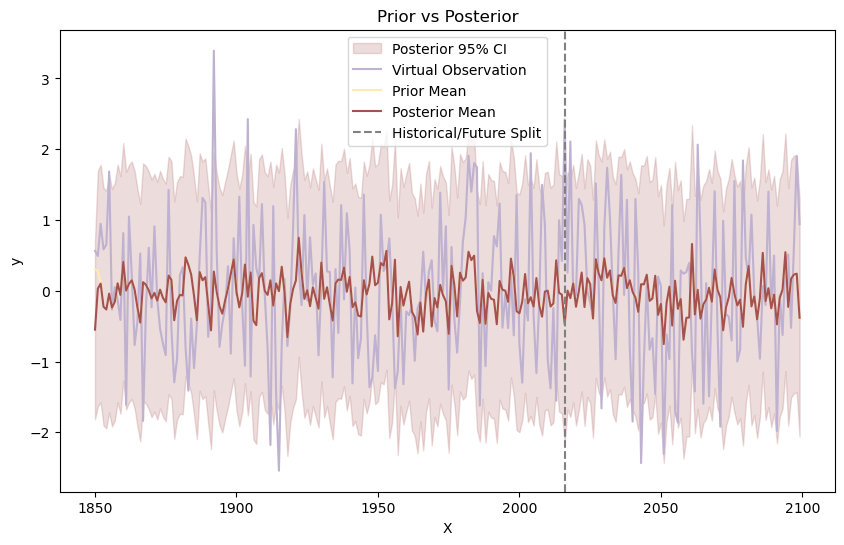

In [38]:
def rbf(best_params):
    combined_kernel = (
        C(best_params['constant_rbf']) * RBF(length_scale=best_params['rbf_length']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return combined_kernel

pbounds = {
    'rbf_length': (1e-2, 10),   
    'noise_level': (1e-6, 1),
    'constant_rbf': (1e-3, 1),   
}

kernel_tune(mod_ids, Nobs, rainfall_yearly, pbounds, rbf)